# Demonstration of Compiling Models using the Intel NPU Acceleration Library

In this code demonstration, we will explore how to utilize the `intel_npu_acceleration_library` to compile a neural network model for optimized execution on the NPU.

The Intel NPU Acceleration Library is currently in active development, and our team in working to introduce a variety of features that are anticipated to dramatically enhance performance of running AI models on the NPU.

One of the main aims of this library is to enable model compilation support that allows to push blocks of a model at a time for the NPU, instead of breaking the model down lower individual layers.

Currently, when compiling an entire model there are only a few layers of the model that are being run on the NPU, however we are working on improving the compilation of models to run more of the model's operations on the NPU.

To use the `intel_npu_acceleration_library` package, it needs to be installed in the Python environment. You can install it by running the following command in a code cell:

```bash
!pip install intel_npu_acceleration_library
```
Once the library is installed, you can import the library into your Python script. 

In [1]:
import intel_npu_acceleration_library as npu_lib

## Run a single block of a model on the CPU and NPU
To get familiar with the workflow of using the library to compile a model for the NPU, we first focus on compiling a single MLP block.

In the following example, we use the `Phi-3 MLP` block from the `phi3` model in the `transformers` library.

For a single block, you just need to call the `intel_npu_acceleration_library.compile` function with your the block and the compiler configuration `CompilerConfig` to compile and optimize the block for the NPU.

To compile and optimize a single layer of a model to be pushed to the NPU as one block, we set `use_to=True` in the the compiler configuration `CompilerConfig`.

In the `CompilerConfig`, you can also select one of the following supported data types: `float16`, `int8` or `int4`.



In [2]:
from transformers.models.phi3.modeling_phi3 import Phi3Config, Phi3MLP
from intel_npu_acceleration_library.compiler import CompilerConfig
import torch


# Define configuration parameters for a single Phi-3 MLP layer
conf = Phi3Config.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
conf.num_hidden_layers = 1
conf.hidden_size = 256
conf.intermediate_size = 512
seq_len = 128

# Define a single Phi-3 MLP layer
mlp = Phi3MLP(conf)
print(mlp)

# Defining the compiler config and compiling the model
compiler_conf = CompilerConfig(use_to=True, dtype=torch.float16)
model = npu_lib.compile(mlp, compiler_conf)

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

Phi3MLP(
  (gate_up_proj): Linear(in_features=256, out_features=1024, bias=False)
  (down_proj): Linear(in_features=512, out_features=256, bias=False)
  (activation_fn): SiLU()
)


To compare the execution of CPU and NPU modes, we can use the `timeit` magic command in Jupyter Notebook. Here's the code:

In [11]:
hidden_states = torch.rand((seq_len, conf.hidden_size))

print("CPU:")
%timeit -n 500 mlp(hidden_states)

print("NPU:")
%timeit -n 500 model(hidden_states)

CPU:
934 μs ± 93.3 μs per loop (mean ± std. dev. of 7 runs, 500 loops each)
NPU:
1.36 ms ± 342 μs per loop (mean ± std. dev. of 7 runs, 500 loops each)


## Compile and Run the Florence-2 Model on the NPU
Previously we have seen how we can compile a single MLP block, and now we can look to compile an entire model for the NPU.

In the following example, we use the `Florence-2` model.

In using this model, there is a dependency on the `flash-attn` library. To work around this, we bypass the transformers `dynamic_module_utils` function `get_imports` which lists `flash_attn` as requirement.

The workaround is found at the following link: https://huggingface.co/microsoft/Florence-2-base/discussions/4


In [12]:
import os
from unittest.mock import patch
from transformers.dynamic_module_utils import get_imports
from transformers import AutoModelForCausalLM, AutoProcessor

# Workaround for the flash_attn requirement
def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    if not str(filename).endswith("modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports

# Using the Florence-2 Model
model_id = "microsoft/Florence-2-large"

with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports):
    model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, attn_implementation="sdpa")
    image_processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)



pytorch_model.bin:  27%|##6       | 409M/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

c:\Users\Local_Admin\wa1\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Now we can compile the model for the NPU, again using the `intel_npu_acceleration_library.compile` function and the compiler configuration `CompilerConfig`.

In the `CompilerConfig`, the `use_to` parameter is set to `False` by default which is used when compiling an entire model. 

In [13]:
# Defining the compiler config and compiling the model
compiler_conf = CompilerConfig(dtype=torch.float16)
model = npu_lib.compile(model, compiler_conf)

Using the compiled model, we can run infernce by passing a url of an image to the model which will generate a caption for the image.

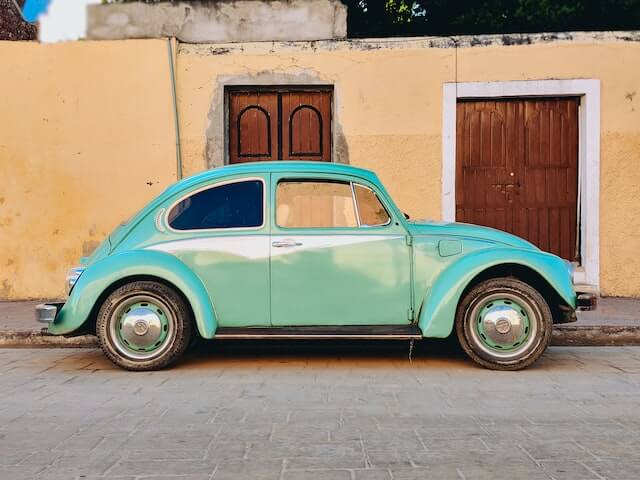

In [14]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)
image

In [15]:
import time
import textwrap

# The task for the model
prompt = '<DETAILED_CAPTION>'
print(f"Model Prompt: {prompt}")

# Generating the inputs for the model
inputs = image_processor(text=prompt, images=image, return_tensors="pt")

# Running model inference
print(f"Running model inference using {model_id}")
start = time.time()
generated_ids = model.generate(
    input_ids=inputs["input_ids"], 
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    early_stopping=False,
    do_sample=False,
    num_beams=3
)
end = time.time()
elapsed_time = end - start
print(f"Execution time: {elapsed_time:.3f} sec")

# Decoding output of the model
generated_text = image_processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
parsed_answer = image_processor.post_process_generation(
    generated_text, 
    task=prompt, 
    image_size=(image.width, image.height)
)

print(f"\nGenerated Image Caption: ")
print(textwrap.fill(parsed_answer[prompt], width=80))

Model Prompt: <DETAILED_CAPTION>
Running model inference using microsoft/Florence-2-large


OSError: [WinError -529697949] Windows Error 0xe06d7363

## Compile and Run the Phi-3 Model on the NPU
In the following example, we use the `Phi-3-mini-4k-instruct` model to demonstrate compiling a different model for the NPU.

Instead of using `AutoModelCausalLM.from_pretrained()` to define the model, we can also use the corresponding wrapper from the `intel_npu_acceleration_library`. 

The `NPUModelForCausalLM.from_pretrained()` class is used from the library which takes in the compiler configuration `CompilerConfig` as a parameter and automatically compiles the model.

First, restart the kernel to clear the memory from running the previous model.

Since we restart the kernel, we need to import the library again.

In [2]:
import intel_npu_acceleration_library as npu_lib

Next, we compile the `Phi-3-mini-4k-instruct` model using the `int4` data type from the `intel_npu_acceleration_library` as a parameter to the `CompilerConfig`.

In [3]:
from transformers import AutoTokenizer, pipeline, TextStreamer
from intel_npu_acceleration_library.compiler import CompilerConfig
import warnings
import torch

torch.random.manual_seed(0)

# Using the Phi-3 Model
model_id = "microsoft/Phi-3-mini-4k-instruct"

# Defining the compiler config and compiling the model
compiler_conf = CompilerConfig()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    compiled_model = npu_lib.NPUModelForCausalLM.from_pretrained(
        model_id,
        config=compiler_conf,
        torch_dtype="auto",
    )

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
streamer = TextStreamer(tokenizer, skip_prompt=True)


We define the messages we want to input into the model and generate the pipeline for model inference, before finally running model inference.

In [4]:
# Input messages for the model
messages = [
    {
        "role": "system",
        "content": "You are a helpful digital assistant.",
    },
    {
        "role": "user",
        "content": "I am going to Paris, briefly give me a list of three tourist attractions I should visit?",
    },
]

# Defining pipeline for model inference
pipe = pipeline(
    "text-generation",
    model=compiled_model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.5,
    "do_sample": True,
    "streamer": streamer,
}

# Running model inference
print(f"Running model inference using {model_id} \n")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe(messages, **generation_args)

You are not running the flash-attention implementation, expect numerical differences.


Running model inference using microsoft/Phi-3-mini-4k-instruct 

For a brief visit to Paris, here are three iconic tourist attractions you should not miss:

1. **Eiffel Tower**: The Eiffel Tower is an iron lattice tower located on the Champ de Mars and is one of the most recognizable structures in the world. It offers stunning views of Paris, and you can ascend it to enjoy panoramic views of the city.

2. **The Louvre Museum**: As the world's largest art museum and a historic monument in Paris, the Louvre is home to thousands of works of art, including the Mona Lisa and the Venus de Milo. It's a must-visit for art lovers and history buffs.

3. **Notre-Dame Cathedral**: This medieval Catholic cathedral is known for its French Gothic architecture, stunning rose windows, and its historical significance. While it suffered a devastating fire in April 2019, it's currently under restoration and remains a symbol of Paris's rich history.

These three attractions will give you a taste of Paris's